# PyTorch를 이용해서 CIFAR 10 이미지 분류 해보기

# 딥러닝 모델을 학습시키기 위해 준비되어야 할 4가지 요소

1. 데이터
2. 모델
3. Loss function (손실함수, 목적함수, objective function 등으로 불려요): 정답과 모델의 예측값을 어떤 식으로 비교할지 결정해주는 함수
4. Optimizer: gradient descent를 해줄 애. 즉, 모델의 파라미터를 어느 방향으로 조금 수정할지 결정하고 수정해주는 함수

In [2]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

## 모델에 데이터 넣을 준비하기

우선 사용하고 싶은 데이터 파일이 있다면 그걸 우선 numpy array 형식으로 불러와야 해요<br/>
그리고는 필요한 전처리를 해준 후에 이 numpy array를 `torch.*Tensor` 형식으로 변환하고 <br/>
dataloader에 넣어주면 pytorch로 짠 딥러닝 모델에 넣을 준비가 된 것입니다.<br/>

대개 이제 이런 데이터 처리를 도와주는 패키지들이 있는데<br/>
이미지는 openCV, Pillow를 많이 쓰고,<br/>
텍스트에는 SpaCy를 많이 사용해요. <br/>

그런데 pytorch에서 고맙게도 그 데이터를 불러오고 전처리를 하는 걸<br/>
파이토치와 매끄럽게 잘 이어지도록 도와주는 패키지를 만들었놨어요.<br/>
* [torchvision](https://pytorch.org/docs/stable/torchvision/index.html#)
* [torchtext](https://torchtext.readthedocs.io/en/latest/)

몇몇 대표 데이터셋들은 해당 패키지에 이미 들어있어서<br/>
그냥 가져다 불러와서 쓰고 몇몇 처리만 해주면 사용할 준비가 끝나요!

이번에는 CIFAR 10이라는 데이터셋을 사용합니다.<br/>
이는 대표적인 데이터셋 중 하나라서 기억해두시면 이따금씩 보일 거예요.<br/>
클래스가 10개라서 CIFAR 10입니다.<br/>

들어있는 클래스는<br/>
‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’ 입니다.<br/>
size는 3x32x32이고 앞의 3은 RGB여서 그런 거예요.<br/>

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# 이미지는 RGB  3가지의 채널로 이루어져있으므로, 각 채널에 대한 mean, std를 넣어줘서 normalize해줘야 해요
# 이미지 데이터의 값이 0~1 사이였는데 이를 통해 -1 ~ +1 사이로 변환해줍니다.

batchsize = 16

# 너무나 간단합니다. torchvision에 이미 다 알아서 처리가 되어있어서 이렇게 편하게 불러올 수 있는 거예요!
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=2)

# 이런 클래스들이 데이터셋 안에 있습니다.
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 41692107.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 학습 이미지 예시 보기

32x32짜리 이미지라서 화질이 안 좋은 건 자연스러운 일입니다... <br/>
놀랍게도 이런 이미지들로 학습을 합니다.

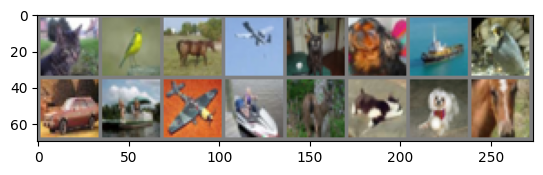

정답:  cat  		  bird  		 horse  		 plane


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # 아까 앞에서 normalize해줘서 색깔 이미지가 이상해져있을 거기 때문에 보기 편하라고 다시 unnormalize해줍니다
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
#images, labels = dataiter.next()
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print( '정답:' + '  \t\t '.join('%5s' % classes[labels[j]] for j in range(4)))

## 모델 정의하기

앞선  notMNIST는 흑백 이미지라서 채널이 1개였지만 <br/>
여기서는 컬러 이미지라서 채널이 3개라는 거에 유의합니다.

In [5]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        ############### fc layer를 완성해보세요 ################
        # batch size=16, 3 input image channel, 6? output channels, 3*3 square 필터사용(kernel사이즈)
        # convolution, 클래스 개수는 10  #kernal = 2, stride = 2, padding = 0 (default)
        # inputs의 모양은 (16, 3, 32, 32) #input = 3, output = 6, kernal = 5
        #Conv2d(입력채널수, 출력채널수, kernel(필터사이즈)크기)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)#(16*16으로 바뀐)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #input feature, output feature
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)#
        self.fc3 = nn.Linear(84, 10)#
        self.relu = nn.ReLU()
        ########################################################

# batch size가 16이 되어야 하는데 54가 나오는 것은 왜인가? 
# conv2d(3,6,5 stride=1,padding=1), fc1(16*5*5,120). x.view(-1,16*5*5)

#flatten 과정이다.
    def forward(self, x):
        #x = self.conv1(x)
        #x = self.relu(x)
        #x = self.pool(x)
        
        # 위를 압축해서 쓴 게 아래 줄이에요!
        x = self.pool(self.relu(self.conv1(x)))
        
        ############### 빈칸을 완성 해보세요 ################
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 400)  # 얘의 기능은 텐서의 모양을 원하는 모양으로 바꿔주는 거예요
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        ########################################################

        return x


net = Net()

## Loss function과 Optimizer 정의하기

Cross-entropy loss function과 SGD optimizer를 씁니다.


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)  # Learning rate: 학습률. 한 번의 optimizer step에서 얼마나 멀리 갈지. 

## 모델 학습시키기

이제
* data loader
* model
* loss function
* optimizer

이 4가지가 모두 준비되었으니 학습을 할 준비가 끝났습니다.

```
종료 조건 만족할 때까지 아래를 반복:
    1. 우리의 data loader로부터 데이터를 받아와서 모델에 넣어주고
    2. 모델의 출력 값을 받아서 
    3. loss function 값을 계산하고
    4. 그 loss를 바탕으로 backprop(=gradient를 계산) 해준 뒤 
    5. optimizer가 gradient descent를 1 step 진행합니다.
    ```

### 근데...

학습을 하면서 테스트셋 성적이 어떻게 변하는지를 보는 건 어때요?

In [7]:
training_loss_history = []
test_loss_history = []

In [8]:
for epoch in range(10):  # 전체 데이터셋을 몇 번 반복할 건지

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # trainloader로부터 데이터와 라벨을 받아옵니다.
        inputs, labels = data

        # 매 반복마다 이전 gradient를 한 번 지워줍니다.
        optimizer.zero_grad()

        # 모델에 데이터 넣어서 forward 해주고 
        # backprop으로 이번 input에 대해 gradient를 계산해주고
        # optimizer가 gradient descent 1스텝 진행
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 결과치 화면에 뿌려주기
        running_loss += loss.item()
        if i % 200 == 199:    # 200 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))

            # 나중에 시각화를 위해 중간중간 따로 loss값 저장
            training_loss_history.append(running_loss / 200)
            
            with torch.no_grad():
                running_test_loss = 0.0
                for i, test_data in enumerate(testloader, 0):
                    test_images, test_labels = test_data
                    test_outputs = net(test_images)
                    test_loss = criterion(test_outputs, test_labels)
                    running_test_loss += test_loss.item()
                
                test_loss_history.append(running_test_loss / i)
                    
            running_loss = 0.0
                    
print('학습 끝!')

[1,   200] loss: 2.298
[1,   400] loss: 2.169
[1,   600] loss: 2.023
[1,   800] loss: 1.934
[1,  1000] loss: 1.829
[1,  1200] loss: 1.734
[1,  1400] loss: 1.679
[1,  1600] loss: 1.595
[1,  1800] loss: 1.589
[1,  2000] loss: 1.572
[1,  2200] loss: 1.511
[1,  2400] loss: 1.541
[1,  2600] loss: 1.466
[1,  2800] loss: 1.463
[1,  3000] loss: 1.414
[2,   200] loss: 1.378
[2,   400] loss: 1.366
[2,   600] loss: 1.366
[2,   800] loss: 1.381
[2,  1000] loss: 1.396
[2,  1200] loss: 1.394
[2,  1400] loss: 1.356
[2,  1600] loss: 1.350
[2,  1800] loss: 1.335
[2,  2000] loss: 1.300
[2,  2200] loss: 1.322
[2,  2400] loss: 1.308
[2,  2600] loss: 1.335
[2,  2800] loss: 1.327
[2,  3000] loss: 1.324
[3,   200] loss: 1.236
[3,   400] loss: 1.271
[3,   600] loss: 1.252
[3,   800] loss: 1.265
[3,  1000] loss: 1.285
[3,  1200] loss: 1.218
[3,  1400] loss: 1.244
[3,  1600] loss: 1.251
[3,  1800] loss: 1.230
[3,  2000] loss: 1.236
[3,  2200] loss: 1.275
[3,  2400] loss: 1.253
[3,  2600] loss: 1.233
[3,  2800] 

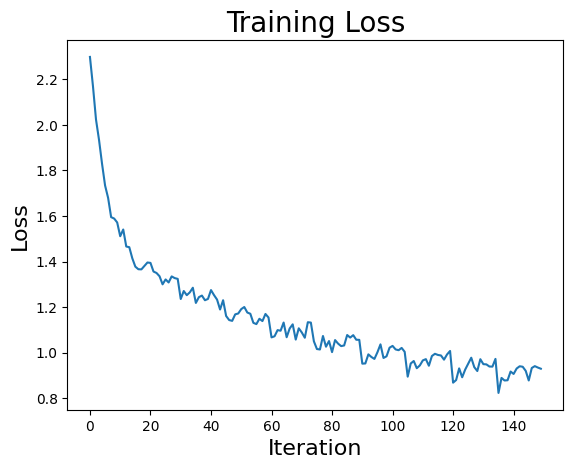

In [9]:
plt.plot(training_loss_history) 
plt.title('Training Loss', fontsize=20)  # 여기에 한글을 넣고 싶으시다구요? 그럼 좀 귀찮은 몇 가지 작업들을 해야 합니다... 그러므로 패스
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.show()

[그래도 난 matplotlib에 한글을 넣겠어!](https://programmers.co.kr/learn/courses/21/lessons/950)

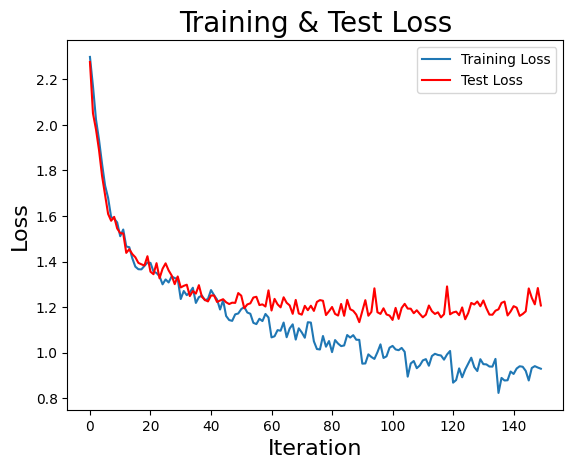

In [10]:
plt.plot(training_loss_history, label="Training Loss") 
plt.plot(test_loss_history, 'r', label="Test Loss") 
plt.title('Training & Test Loss', fontsize=20) 
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.show()

## 모델 저장하기

학습이 끝난 모델의 파라미터를 저장해두면 나중에 필요할 때 불러와서 가져다 쓰면 바로 사용할 수 있어요.

In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 테스트셋에 검증해보기

이제 모델 학습이 끝났으니 테스트 데이터에도 잘하는지 확인을 해봐야 합니다. <br/>
테스트셋 데이터 중 몇 개나 맞히는지 알아볼까요?

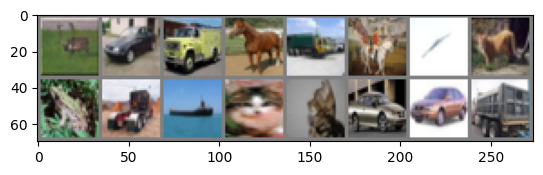

In [12]:
# 테스트셋 이미지 예시도 심심풀이로 한 번 확인해보기
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=2)

images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images))

#오류 떠서 위와 같이 수정했습니다. 다음 학기에는 이 부분을 반드시 고쳐주시길 부탁드립니다.

### 아까 저장해뒀던 모델 파라미터 불러오기

사실 굳이 불러오지 않고 그냥 위에 있는 `net` 그대로 써도 되지만 <br/>
일단 어떻게 저장하고 불러오는지 여러분이 알아둬야 하니까 여기서는 `net`에 굳이 다시 불러와봤어요

In [13]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

이미지들을 넣었을 때 모델이 뭐라고 예측하는지 한 번 확인해볼게요.

In [14]:
outputs = net(images)
outputs

tensor([[ 2.4620e-01, -5.6094e+00,  2.8164e+00,  3.5989e-01,  4.9672e+00,
          1.2703e-02, -1.0495e+00,  1.6886e+00, -1.0032e+00, -3.2779e+00],
        [ 1.0073e-01,  4.4498e+00,  1.4072e+00, -1.1539e+00, -6.0958e-01,
         -1.5601e+00,  1.2887e+00,  1.4569e+00, -3.7186e+00,  1.7607e+00],
        [-2.8158e-01,  8.9028e+00, -1.8601e+00, -1.9154e+00, -4.8755e+00,
         -6.0542e+00,  2.1381e+00, -3.8083e+00, -3.8567e+00,  1.4998e+01],
        [-5.1118e+00, -3.7755e+00,  1.3439e+00,  2.1660e+00,  3.9595e+00,
          3.0989e+00,  1.0834e+00,  8.8654e+00, -6.1236e+00, -2.7534e+00],
        [ 4.9603e+00,  4.6758e-01, -1.7626e+00, -9.9986e-01, -1.1032e+00,
         -4.0716e+00, -2.6110e-01, -4.3375e+00,  2.3545e+00,  4.3083e+00],
        [-4.3467e-01, -2.0397e+00, -9.3037e-02,  1.3116e+00,  7.9603e-01,
          1.8819e+00, -1.1937e-01,  1.7565e+00, -1.9038e+00, -1.9571e+00],
        [ 4.5002e+00, -5.2831e+00,  3.3174e+00,  3.0144e+00,  6.5032e-01,
          1.8320e+00, -2.8914e+0

뭔지 전혀 모르겠죠? <br/>
각 row에 있는 숫자들은 10개의 클래스에 대한 logit 값이에요. (확률 값이 아니라) <br/>
어떤 인덱스의 logit값이 크면 모델은 그 해당 인덱스의 클래스로 해당 이미지를 분류한다는 의미입니다. <br/>
따라서 그냥 이 logit 값들 중 제일 큰 logit이 있는 index를 각 row마다 뽑아오면 됩니다. <br/>

In [15]:
_, predicted = torch.max(outputs, 1)  # 1번째 차원(=각 row)에서 각각 max인 값과 해당 index를 뽑아옵니다.
#스켈레톤 코드 자체가 잘못되었는데 결과가 잘 나올리가 없다.
print('모델 예측: ', ', '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

모델 예측:   deer,   car, truck, horse


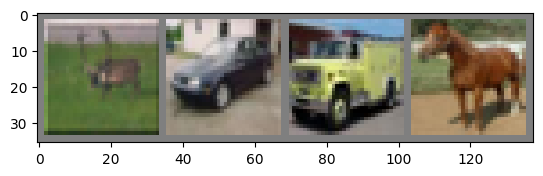

실제 정답:   deer,   car, truck, horse
모델 예측:   deer,   car, truck, horse


In [16]:
# 원래 이미지랑 같이 볼까요? #스켈레톤 코드 자체가 잘못되었는데 결과가 잘 나올리가 없다.
imshow(torchvision.utils.make_grid(images[:4]))
print('실제 정답: ', ', '.join('%5s' % classes[labels[j]] for j in range(4)))
print('모델 예측: ', ', '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

나름 잘 맞히는 거 같습니다. <br/>
그러면 이제 전체 테스트셋에 대해 정답과 비교해서 몇 개나 맞히는지 보겠습니다. 

### 테스트셋 정답률 확인해보기

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('10000개의 테스트 이미지에 대한 정답률: %d %%' % (
    100 * correct / total))

10000개의 테스트 이미지에 대한 정답률: 60 %


### 각 클래스 별 정답률 확인해보기

In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():  # 매우매우 중요! 테스트셋으로 학습하는 건 반칙입니다. 테스트셋으로 backprop을 하면 안 되지요.
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('%5s 클래스의 정답률 : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

plane 클래스의 정답률 : 56 %
  car 클래스의 정답률 : 79 %
 bird 클래스의 정답률 : 52 %
  cat 클래스의 정답률 : 56 %
 deer 클래스의 정답률 : 47 %
  dog 클래스의 정답률 : 36 %
 frog 클래스의 정답률 : 69 %
horse 클래스의 정답률 : 59 %
 ship 클래스의 정답률 : 70 %
truck 클래스의 정답률 : 69 %


# 과제:

### 1.ipynb 파일 제출 (10점)
convolution layer **2층** 이상의 convnet을 만들어서 <br/>
테스트 데이터에 대한 정답률을 높여서 ipynb 파일을 제출을 하시면 됩니다! <br/>
모델을 정의하고 이것저것 바꿔보세요. <br/>
**55%**를 넘겨보도록 해보세요!

- 55%를 넘기시면 8점
- 57.5%를 넘기시면 9점
- 60%를 넘기시면 10점

수업 시간에 말한 거 이외의 힌트:<br/>
`self.conv2`가 있어야겠죠 2층을 쌓으려면? <br/>
이건 weight기 때문에 따로 별도로 `self.conv2`가 있어야 하지만 relu나 maxpool은 파라미터가 없기 때문에 있는 거 그대로 쓰시면 되는 거예요! <br/>
과제에서 반드시 convolution layer를 2층 이상을 쌓으셔야 해요. 거기에 추가로 fc layer도 더 쌓으실 수도 있겠죠? <br/>

### 2.실험 결과 설명 제출 (5점)
Learning rate를 크게 해서 돌려보기도 하고 작게 해서 돌려보기도 하면서 각각의 training loss graph를 비교해보세요.<br/>
앞에서 한 것처럼 그래프를 그려보세요. 각 실험에 대한 graph가 노트북 파일 내에 남아있어야 해요. <br/>
그리고 그 성능에 차이가 나는 이유를 생각해서 써보세요. 

## 주의사항
ipynb 파일의 이름은 `[학번]_[이름].ipynb`로 제출하셔야 합니다. 예시: `2019-12321_김학생.ipynb`<br/>
형식을 지키지 않으실 경우 감점 1점 있습니다.

## 실험 결과 설명 작성하는 칸

여기에 작성하세요

[1,   200] loss: 1.028
[1,   400] loss: 1.169
[1,   600] loss: 1.107
[1,   800] loss: 1.198
[1,  1000] loss: 1.191
[1,  1200] loss: 1.174
[1,  1400] loss: 1.181
[1,  1600] loss: 1.186
[1,  1800] loss: 1.183
[1,  2000] loss: 1.193
[1,  2200] loss: 1.264
[1,  2400] loss: 1.206
[1,  2600] loss: 1.222
[1,  2800] loss: 1.205
[1,  3000] loss: 1.210
[2,   200] loss: 1.117
[2,   400] loss: 1.178
[2,   600] loss: 1.189
[2,   800] loss: 1.165
[2,  1000] loss: 1.189
[2,  1200] loss: 1.206
[2,  1400] loss: 1.205
[2,  1600] loss: 1.239
[2,  1800] loss: 1.189
[2,  2000] loss: 1.216
[2,  2200] loss: 1.231
[2,  2400] loss: 1.206
[2,  2600] loss: 1.202
[2,  2800] loss: 1.244
[2,  3000] loss: 1.204
[3,   200] loss: 1.079
[3,   400] loss: 1.129
[3,   600] loss: 1.115
[3,   800] loss: 1.132
[3,  1000] loss: 1.188
[3,  1200] loss: 1.190
[3,  1400] loss: 1.176
[3,  1600] loss: 1.183
[3,  1800] loss: 1.185
[3,  2000] loss: 1.203
[3,  2200] loss: 1.217
[3,  2400] loss: 1.187
[3,  2600] loss: 1.217
[3,  2800] 

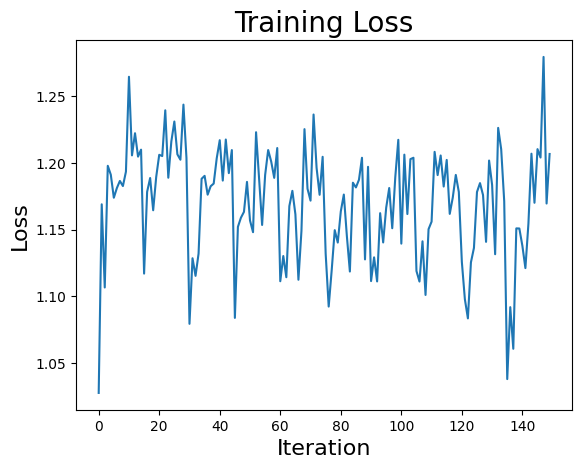

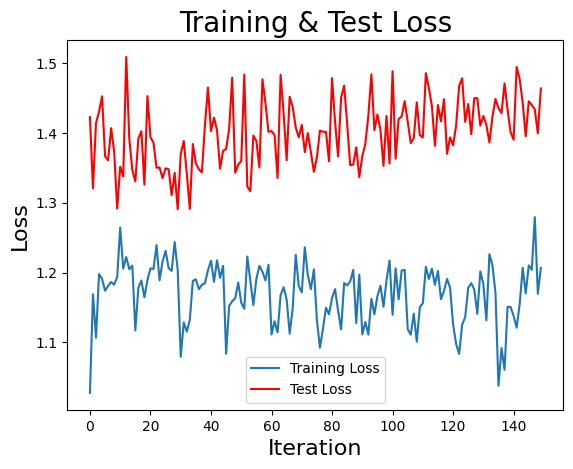

In [19]:
#learning rate = 0.01
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)  # Learning rate: 학습률. 한 번의 optimizer step에서 얼마나 멀리 갈지. 

training_loss_history = []
test_loss_history = []

for epoch in range(10):  # 전체 데이터셋을 몇 번 반복할 건지

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # trainloader로부터 데이터와 라벨을 받아옵니다.
        inputs, labels = data

        # 매 반복마다 이전 gradient를 한 번 지워줍니다.
        optimizer.zero_grad()

        # 모델에 데이터 넣어서 forward 해주고 
        # backprop으로 이번 input에 대해 gradient를 계산해주고
        # optimizer가 gradient descent 1스텝 진행
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 결과치 화면에 뿌려주기
        running_loss += loss.item()
        if i % 200 == 199:    # 200 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))

            # 나중에 시각화를 위해 중간중간 따로 loss값 저장
            training_loss_history.append(running_loss / 200)
            
            with torch.no_grad():
                running_test_loss = 0.0
                for i, test_data in enumerate(testloader, 0):
                    test_images, test_labels = test_data
                    test_outputs = net(test_images)
                    test_loss = criterion(test_outputs, test_labels)
                    running_test_loss += test_loss.item()
                
                test_loss_history.append(running_test_loss / i)
                    
            running_loss = 0.0
                    
print('학습 끝!')

plt.plot(training_loss_history) 
plt.title('Training Loss', fontsize=20)  # 여기에 한글을 넣고 싶으시다구요? 그럼 좀 귀찮은 몇 가지 작업들을 해야 합니다... 그러므로 패스
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.show()

plt.plot(training_loss_history, label="Training Loss") 
plt.plot(test_loss_history, 'r', label="Test Loss") 
plt.title('Training & Test Loss', fontsize=20) 
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.show()

[1,   200] loss: 0.988
[1,   400] loss: 0.893
[1,   600] loss: 0.854
[1,   800] loss: 0.872
[1,  1000] loss: 0.848
[1,  1200] loss: 0.844
[1,  1400] loss: 0.866
[1,  1600] loss: 0.812
[1,  1800] loss: 0.811
[1,  2000] loss: 0.824
[1,  2200] loss: 0.806
[1,  2400] loss: 0.799
[1,  2600] loss: 0.827
[1,  2800] loss: 0.822
[1,  3000] loss: 0.849
[2,   200] loss: 0.780
[2,   400] loss: 0.734
[2,   600] loss: 0.777
[2,   800] loss: 0.753
[2,  1000] loss: 0.743
[2,  1200] loss: 0.752
[2,  1400] loss: 0.769
[2,  1600] loss: 0.757
[2,  1800] loss: 0.749
[2,  2000] loss: 0.747
[2,  2200] loss: 0.718
[2,  2400] loss: 0.735
[2,  2600] loss: 0.788
[2,  2800] loss: 0.746
[2,  3000] loss: 0.749
[3,   200] loss: 0.693
[3,   400] loss: 0.664
[3,   600] loss: 0.710
[3,   800] loss: 0.666
[3,  1000] loss: 0.692
[3,  1200] loss: 0.732
[3,  1400] loss: 0.734
[3,  1600] loss: 0.702
[3,  1800] loss: 0.673
[3,  2000] loss: 0.709
[3,  2200] loss: 0.689
[3,  2400] loss: 0.711
[3,  2600] loss: 0.724
[3,  2800] 

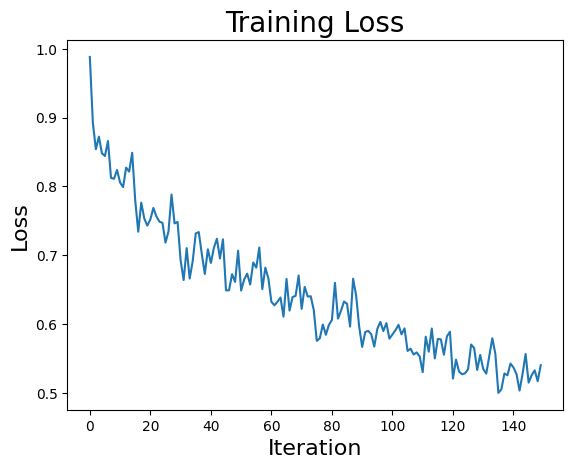

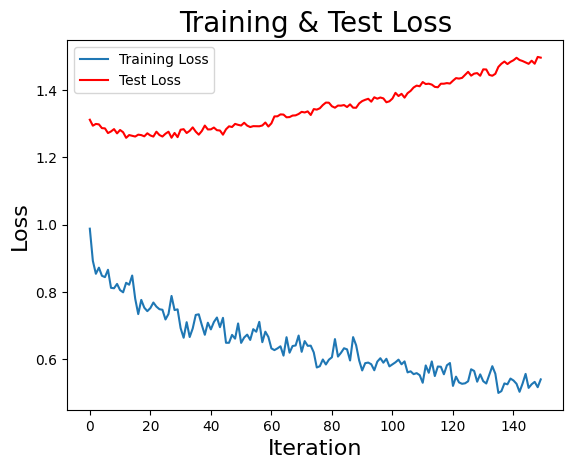

In [20]:
#learning rate = 0.001
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # Learning rate: 학습률. 한 번의 optimizer step에서 얼마나 멀리 갈지. 

training_loss_history = []
test_loss_history = []

for epoch in range(10):  # 전체 데이터셋을 몇 번 반복할 건지

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # trainloader로부터 데이터와 라벨을 받아옵니다.
        inputs, labels = data

        # 매 반복마다 이전 gradient를 한 번 지워줍니다.
        optimizer.zero_grad()

        # 모델에 데이터 넣어서 forward 해주고 
        # backprop으로 이번 input에 대해 gradient를 계산해주고
        # optimizer가 gradient descent 1스텝 진행
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 결과치 화면에 뿌려주기
        running_loss += loss.item()
        if i % 200 == 199:    # 200 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))

            # 나중에 시각화를 위해 중간중간 따로 loss값 저장
            training_loss_history.append(running_loss / 200)
            
            with torch.no_grad():
                running_test_loss = 0.0
                for i, test_data in enumerate(testloader, 0):
                    test_images, test_labels = test_data
                    test_outputs = net(test_images)
                    test_loss = criterion(test_outputs, test_labels)
                    running_test_loss += test_loss.item()
                
                test_loss_history.append(running_test_loss / i)
                    
            running_loss = 0.0
                    
print('학습 끝!')

plt.plot(training_loss_history) 
plt.title('Training Loss', fontsize=20)  # 여기에 한글을 넣고 싶으시다구요? 그럼 좀 귀찮은 몇 가지 작업들을 해야 합니다... 그러므로 패스
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.show()

plt.plot(training_loss_history, label="Training Loss") 
plt.plot(test_loss_history, 'r', label="Test Loss") 
plt.title('Training & Test Loss', fontsize=20) 
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.show()

[1,   200] loss: 0.499
[1,   400] loss: 0.489
[1,   600] loss: 0.464
[1,   800] loss: 0.484
[1,  1000] loss: 0.483
[1,  1200] loss: 0.486
[1,  1400] loss: 0.480
[1,  1600] loss: 0.460
[1,  1800] loss: 0.486
[1,  2000] loss: 0.478
[1,  2200] loss: 0.486
[1,  2400] loss: 0.473
[1,  2600] loss: 0.469
[1,  2800] loss: 0.466
[1,  3000] loss: 0.463
[2,   200] loss: 0.473
[2,   400] loss: 0.461
[2,   600] loss: 0.479
[2,   800] loss: 0.471
[2,  1000] loss: 0.501
[2,  1200] loss: 0.462
[2,  1400] loss: 0.475
[2,  1600] loss: 0.505
[2,  1800] loss: 0.469
[2,  2000] loss: 0.446
[2,  2200] loss: 0.450
[2,  2400] loss: 0.454
[2,  2600] loss: 0.481
[2,  2800] loss: 0.469
[2,  3000] loss: 0.471
[3,   200] loss: 0.474
[3,   400] loss: 0.455
[3,   600] loss: 0.464
[3,   800] loss: 0.481
[3,  1000] loss: 0.464
[3,  1200] loss: 0.465
[3,  1400] loss: 0.469
[3,  1600] loss: 0.472
[3,  1800] loss: 0.469
[3,  2000] loss: 0.478
[3,  2200] loss: 0.477
[3,  2400] loss: 0.475
[3,  2600] loss: 0.457
[3,  2800] 

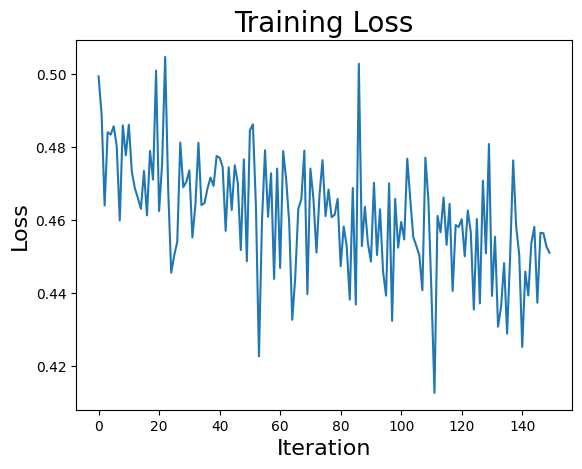

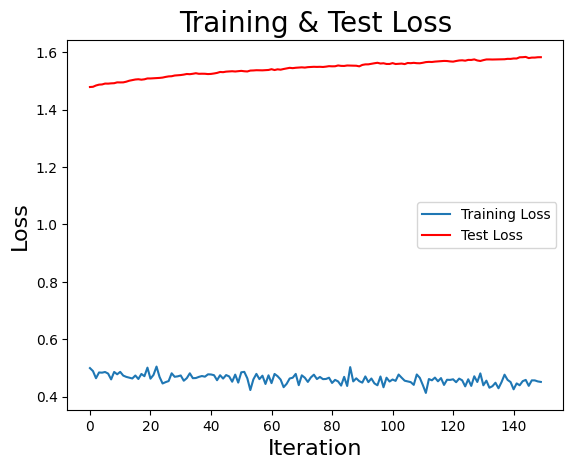

In [21]:
#learning rate = 0.0001
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)  # Learning rate: 학습률. 한 번의 optimizer step에서 얼마나 멀리 갈지. 

training_loss_history = []
test_loss_history = []

for epoch in range(10):  # 전체 데이터셋을 몇 번 반복할 건지

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # trainloader로부터 데이터와 라벨을 받아옵니다.
        inputs, labels = data

        # 매 반복마다 이전 gradient를 한 번 지워줍니다.
        optimizer.zero_grad()

        # 모델에 데이터 넣어서 forward 해주고 
        # backprop으로 이번 input에 대해 gradient를 계산해주고
        # optimizer가 gradient descent 1스텝 진행
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 결과치 화면에 뿌려주기
        running_loss += loss.item()
        if i % 200 == 199:    # 200 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))

            # 나중에 시각화를 위해 중간중간 따로 loss값 저장
            training_loss_history.append(running_loss / 200)
            
            with torch.no_grad():
                running_test_loss = 0.0
                for i, test_data in enumerate(testloader, 0):
                    test_images, test_labels = test_data
                    test_outputs = net(test_images)
                    test_loss = criterion(test_outputs, test_labels)
                    running_test_loss += test_loss.item()
                
                test_loss_history.append(running_test_loss / i)
                    
            running_loss = 0.0
                    
print('학습 끝!')

plt.plot(training_loss_history) 
plt.title('Training Loss', fontsize=20)  # 여기에 한글을 넣고 싶으시다구요? 그럼 좀 귀찮은 몇 가지 작업들을 해야 합니다... 그러므로 패스
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.show()

plt.plot(training_loss_history, label="Training Loss") 
plt.plot(test_loss_history, 'r', label="Test Loss") 
plt.title('Training & Test Loss', fontsize=20) 
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.show()
#Learning rate가 작으면 이동하는 간격이 매우 작아 loss를 줄이는 속도가 매우 느려지고,
#Learning rate가 크면 이동하는 간격이 매우 커서 이동할 수 있으나 loss를 줄이는 속도가 매우 커져 섬세한 
#loss 조절이 불가능하게 됩니다. 따라서 적정한 Learning rate를 설정하여 기계학습을 진행해야 최적의 결과를 낼 수 있음을 위 실험을 통해서 알 수 있습니다.




<실험 결론>
epoch를 10번으로 설정했습니다.

Learning rate가 작으면 이동하는 간격이 매우 작아 loss를 줄이는 속도가 매우 느려지고, loss를 줄이는 속도가 매우 커져 섬세한 조절이 불가능하게 됩니다.또 이 실험의 구조적으로 큰 문제는 앞선 실험의 결과가 뒤의 실험에 영향을 준다는 것인데 이것을 고려하여 결론을 분석하면 underfitting이 될 가능성이 큽니다.

Learning rate가 크면 이동하는 간격이 매우 커서 정확한 loss를 줄이는 방향으로 갈 수 없게 됩니다. 0.01을 넣었을 때 움직임이 크기 때문입니다.

따라서 이 모델에서는 적정한 Learning rate(0.001-0.005)를 설정해야 최적의 결과를 낼 수 있음을 위 실험을 통해서 알 수 있습니다.

In [ ]:
# 위 실험 결론을 작성하여 적어 두었습니다.
#seokhee.hong@vision.snu.ac.kr 문의메일


## [덧] GPU 위에서 학습하기

지금까지는 cpu위에서 다 계산을 한 거예요.<br/>
GPU 위에서 저희 모델이 인풋 데이터를 받아서 출력을 계산하고 싶잖아요? <br/>
그러면 해야 할 일은<br/>
모델도 gpu에 보내고, 데이터도 gpu에 보내는 일입니다.<br/>

그러기 위해선 일단 gpu가 사용 가능한지부터 봐야겠죠?<br/>
CUDA available:



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CUDA가 있는 컴퓨터라면 CUDA 라고 뜨고 아니면 cpu라고 뜰 겁니다
print(device)

The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

아래처럼 수정을 해주면 모델이 gpu 위에 올라갑니다

```python
net = net.to(device)
```

데이터도 올려줘야겠죠?

```python
inputs, labels = data[0].to(device), data[1].to(device)
 ```

지금은 모델이 너무 작아서 gpu에서 하든 cpu에서 하든 속도 차이가 별로 없습니다.